In [1]:

from transformers import CLIPImageProcessor, CLIPModel
from transformers import AutoProcessor
import torch
from torch.utils.data import ConcatDataset
import torchvision
import torchvision.transforms.v2 as transforms
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from collections import OrderedDict

/Users/Mikolaj/miniconda3/envs/eds2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset1 = torchvision.datasets.CIFAR10(root='../data/', train=False,
                                          download=True, transform=transforms.ToTensor())

dataset2 = torchvision.datasets.CIFAR10(root='../data/', train=True,
                                          download=True, transform=transforms.ToTensor())


images = np.append(dataset1.data, dataset2.data, axis=0)
labels = dataset1.targets + dataset2.targets
print(images.shape)

/Users/Mikolaj/miniconda3/envs/eds2/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified
(60000, 32, 32, 3)


In [3]:
slice_size = 10000

images_transposed = np.transpose(images, (0,3,1,2))
#images_slice = images_transposed[0:slice_size][:][:][:]

#for i in range(9):
    #np.append(images_slice, images_transposed[slice_size*i, slice_size*(i+1)][:][:][:], axis =0)

#print(images_slice.size)

print(images_transposed.shape)


(60000, 3, 32, 32)


In [4]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
image_processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")

image_embeddings = np.empty((0,512))

# number of images is too large to run clip on all of them so we have to do it in 1000 image batches
for i in range(1):
    images_slice = images_transposed[ (1000*i): (1000*(i+1)) ][:][:][:]

    clip_inputs = image_processor(images=images_slice, return_tensors="pt")
    clip_outputs = model.get_image_features(**clip_inputs).detach()

    image_embeddings = np.append(image_embeddings, clip_outputs, axis=0)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [5]:
print(image_embeddings.shape)

#embeddings_list = image_embeddings[1:]
#image_embeddings = image_embeddings[0]

#for embds in embeddings_list:
    #image_embeddings = np.append(image_embeddings, 

#print(image_embeddings.shape)

(1000, 512)


In [6]:
print(type(image_embeddings))

<class 'numpy.ndarray'>


In [7]:
pca = PCA(n_components=50)
pca_results = pca.fit_transform(image_embeddings)

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(pca_results)

In [8]:
print(tsne_results.shape)

(1000, 2)


In [9]:
def calc_distance(coordinate_1, coordinate_2):
    return np.linalg.norm(coordinate_1 - coordinate_2)


def calc_distances(coords):
    num_coords = coords.shape[0]

    distance_lists = []
    for i in range(num_coords):
        coordinate = coords[i]
        distance_dict = {j : calc_distance(coordinate, coords[j]) for j in range(num_coords)}
        distance_lists.append(distance_dict)

    return distance_lists


def sort_distances(distances_list):
    from collections import OrderedDict

    m = len(distances_list)
    sorted_distances = []

    for i in range(m):
        unsorted_dict = distances_list[i]
        sorted_dict = OrderedDict(sorted(unsorted_dict.items(), key=lambda item: item[1], reverse=True))
        sorted_distances.append(sorted_dict)

    return sorted_distances


def generate_indexes(coords, sorted_distances, batch_size):
    m = coords.shape[0]
    batch = []

    #distances = calc_distances(coords)
    #sorted_distances = sort_distances(distances)

    indx = 0
    rng = np.random.default_rng()
    indx = rng.integers(0, m)
    batch.append(indx)
    prev_indx = indx

    for i in range(batch_size-1):
        distance_dict = sorted_distances[prev_indx]

        for indx, distance in distance_dict.items():
            if indx in batch:
                pass
            else :
                batch.append(indx)
                prev_indx = indx
                break

    return batch
    #yield batch

def generate_indexes_proportional(coords, sorted_distances, batch_size):
    m = coords.shape[0]
    batch = []

    rng = np.random.default_rng()
    indx = rng.integers(0, m)
    batch.append(indx)
    prev_indx = indx

    for i in range(batch_size-1):
        distance_dict = sorted_distances[prev_indx]

        #remove previously used batch indexes from consideration
        for indx in batch:
            if indx in distance_dict.keys():
                distance_dict.pop(indx)

    
        indxs = list(distance_dict.keys())
        distances = list(distance_dict.values())

        probabilities = np.array(distances) / sum(distances)

        indx = np.random.choice(indxs, p=probabilities)

        batch.append(indx)
        prev_indx = indx


    return batch


In [10]:
distances = calc_distances(tsne_results)
sorted_distances = sort_distances(distances)

In [11]:
batch_size = 100
batch_indexes = generate_indexes_proportional(tsne_results, sorted_distances, batch_size)

In [12]:
#def plot_batch_elements(embeddings, batch_indexes):
    #column_vals = ['x1', 'x2']

    #df = pd.DataFrame(data = embeddings, columns=column_vals)

    #m = tsne_results.shape[0]
    #chosen = ['not chosen' for x in range(m)]
    #for indx in batch_indexes:
        #chosen[indx] = 'batch element'

    #df['label'] = chosen

    #hue_order = ['not chosen', 'batch element']
    #df_sorted = df.sort_values('label', key=np.vectorize(hue_order.index))

    #plot = sns.scatterplot(x='x1', y='x2', data=df_sorted, hue='label', ec=None, palette="deep")
    #plot.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)


#def plot_batch_order(embeddings, batch_indexes, batch_size, type='inclusive'):
    #column_vals = ['x1', 'x2']

    #df = pd.DataFrame(data = embeddings, columns=column_vals)

    #m = tsne_results.shape[0]
    #chosen = ['not chosen' for x in range(m)]
    #for indx in batch_indexes:
        #chosen[indx] = 'batch element'

    #df['label'] = chosen

    #df['batch_order'] = 0

    #if (type == 'inclusive'):
        #for i, batch_index in enumerate(batch_indexes):
            #df.at[batch_index, 'batch_order'] = batch_size + i

        #hue_order = ['not chosen', 'batch element']
        #df_sorted = df.sort_values('label', key=np.vectorize(hue_order.index))

        #plot = sns.scatterplot(x='x1', y='x2', data=df_sorted, hue='batch_order', ec=None, legend='brief')
        #plot.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

    #elif (type == 'exclusive'):
        #for i, batch_index in enumerate(batch_indexes):
            #df.at[batch_index, 'batch_order'] = i


        #hue_order = ['not chosen', 'batch element']
        #df_sorted = df.sort_values('label', key=np.vectorize(hue_order.index))

        ##df_sorted = df_sorted.drop(df_sorted[df_sorted['label'] == 'not chosen'])
        #df_sorted = df_sorted[df_sorted['label'] == 'batch element']
        #plot = sns.scatterplot(x='x1', y='x2', data=df_sorted, hue='batch_order', ec=None, legend='brief')
        #plot.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)



    ##hue_order = ['not chosen', 'batch element']
    ##df_sorted = df.sort_values('label', key=np.vectorize(hue_order.index))

    ##plot = sns.scatterplot(x='x1', y='x2', data=df_sorted, hue='batch_order', ec=None, legend='brief')
    ##plot.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)


##plot_batch_elements(tsne_results, batch_indexes)

plot_batch_order(tsne_results, batch_indexes, batch_size, type='inclusive')

NameError: name 'plot_batch_order' is not defined

In [37]:
column_vals = ['x1', 'x2']

df = pd.DataFrame(data = tsne_results, columns=column_vals)

m = tsne_results.shape[0]
chosen = ['not chosen' for x in range(m)]
for indx in batch_indexes:
    chosen[indx] = 'batch element'

df['label'] = chosen

df['batch_order'] = 0

for i, batch_index in enumerate(batch_indexes):
    df.at[batch_index, 'batch_order'] = batch_size + i

#print(df.iloc[0]['batch_order'])
print(df.dtypes)


x1             float32
x2             float32
label           object
batch_order      int64
dtype: object


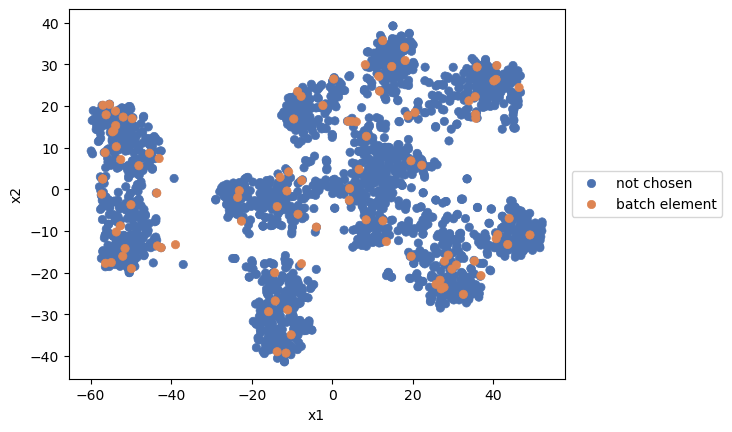

In [ ]:
hue_order = ['not chosen', 'batch element']
df_sorted = df.sort_values('label', key=np.vectorize(hue_order.index))

plot = sns.scatterplot(x='x1', y='x2', data=df_sorted, hue='label', ec=None, palette="deep")
#plot = sns.scatterplot(x='x1', y='x2', data=df_sorted, hue='batch_order', ec=None, legend='brief')
plot.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

In [21]:
gen = np.random.default_rng()
indx = gen.integers(0, m)
print(indx)

805


In [16]:
import random

# Example dictionary
my_dict = {'apple': 1.5, 'pear': 3, 'orange': 6}

# Use random.choices with the dictionary keys and weights (values from the dictionary)
chosen_fruit = random.choices(list(my_dict.keys()), weights=list(my_dict.values()), k=1)[0]

print(chosen_fruit)


apple


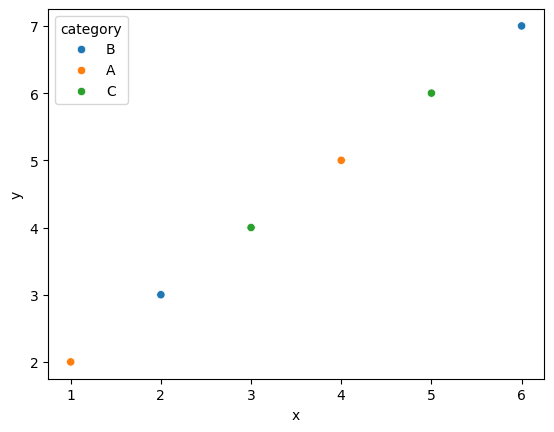

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Sample data
data = {
    'x': [1, 2, 3, 4, 5, 6],
    'y': [2, 3, 4, 5, 6, 7],
    'category': ['A', 'B', 'C', 'A', 'C', 'B']
}

# Create a DataFrame
df = pd.DataFrame(data)

# Scatterplot with hue_order parameter
sns.scatterplot(data=df, x='x', y='y', hue='category', hue_order=['B', 'A', 'C'])

# Display the plot
plt.show()
